In [61]:
from nbmultitask import ProcessWithLogAndControls
from IPython.display import clear_output
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from time import sleep

def fn(x):
    while True:
        print(x.value)
        x.value = x.value**1.01
        sleep(0.1)

from multiprocessing import Value
x = Value('f',2)
task = ProcessWithLogAndControls(target=fn, args=(x,), name="exponential growth")

In [3]:
#task.control_panel()

In [4]:
task.start()
time.sleep(2)
print(x.value)
time.sleep(2)
print(x.value)
task.stop()

2.3297741413116455
2.80667781829834


In [2]:
def get_pure_tone(freq, duration, sample_rate=44100):
    x = np.linspace(0, duration * freq * 2*np.pi, int(duration*sample_rate), dtype=np.float32)
    return np.sin(x)

In [68]:
def test_func(selector):
    import sounddevice as sd
    import numpy as np
    import time

    tone1 = np.sin(np.linspace(0, 0.05 * 440 * 2*np.pi, int(0.05*44100), dtype=np.float32))
    tone2 = np.sin(np.linspace(0, 0.05 * 880 * 2*np.pi, int(0.05*44100), dtype=np.float32))
    ts1 = np.column_stack((tone1, tone1))
    ts2 = np.column_stack((tone2, tone2))

    sd.default.samplerate = 44100
    stream = sd.OutputStream(samplerate=44100, channels=2, dtype='float32')
    stream.start()

    latency = 0.25
    next_beat = time.time() + latency
    with open('sound_log.csv', 'w') as f:
        f.write("time,id\n")

    beats = 0
    while beats < 40:
        t0 = time.time()
        if t0 < next_beat:
            time.sleep(0.0001)  # not to spin the wheels too much
            continue

        
        with open('sound_log.csv', 'a') as f:
            f.write(",".join([str(x) for x in (t0, 1)]) + "\n")
            
        #sd.play(self.tone)  # has underrun errors, maybe try blocking?
        if selector.value == 1:
            stream.write(ts1)
        else:
            stream.write(ts2)
            
        beats += 1
        next_beat += latency
        
    stream.stop()

In [70]:
selector = mp.Value('f', 0)
#is_running = Value(c_bool, True)
#sc = ProcessWithLogAndControls(target=sound_controller, args=(selector, is_running), name="sounds")
sc = ProcessWithLogAndControls(target=test_func, args=(selector,), name="foo")
sc.start()
time.sleep(2)
selector.value = 1
time.sleep(2)
sc.stop()

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


In [71]:
sc.stop()

In [57]:
ds = np.loadtxt('sound_log.csv', delimiter=',', skiprows=1)

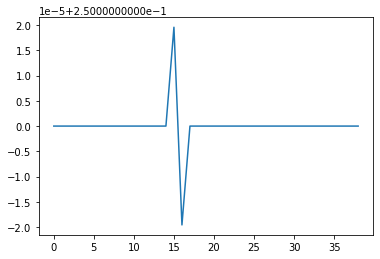

In [58]:
plt.plot(np.diff(ds[:, 0]))

In [ ]:
def get_pure_tone(freq, duration, sample_rate=44100):
    x = np.linspace(0, duration * freq * 2*np.pi, int(duration*sample_rate), dtype=np.float32)
    return np.sin(x)

def sound_controller(selector, is_running, latency=0.25):
    """
    selector        mp.Value object to set the sound to be played
    is_running      mp.Value object to stop the loop
    """
    print('Loading SC..')
    
    tone1 = get_pure_tone(440, 0.05, 44100) * 0.5
    tone2 = get_pure_tone(880, 0.05, 44100) * 0.5
    silence = np.zeros(len(tone1), dtype='float32')    

    sounds = {
        0: np.column_stack((silence, silence)),
        1: np.column_stack((tone1, tone1)),
        2: np.column_stack((tone2, tone2))
    }

    stream = sd.OutputStream(samplerate=44100, channels=2, dtype='float32')
    stream.start()
    
    print('Creating sounds..')
        
    next_beat = time.time() + latency
    beat_times = collections.deque(maxlen=10000)

    
    while is_running.value:
        print('Running loop..')
        
        t0 = time.time()
        if t0 < next_beat:
            continue

        beat_times.append(t0)
        #sd.play(self.tone)  # has underrun errors, maybe try blocking?
        stream.write(sounds[int(selector.value)])
        next_beat += latency
        
    stream.stop()
    print('Sound controller stopped')